# Projection of MD_1 on XRD ensemble PCA

With MDTraj

In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [2]:
residue_selection = "not (resid 622 or resid 623 or resid 624 or resid 933 or resid 934 or resid 935 or resid 1244 or resid 1245 or resid 1246 or resid 0 or resid 1 or resid 2 or resid 311 or resid 312 or resid 313)"

## XRD Ensemble PCA Analyses

In [3]:
#load trajectories
wholetraj = md.load("/home/scottzhuang/tests/ensemble/whole.pdb")
wholetraj.superpose(wholetraj,42)

/home/scottzhuang/anaconda3/envs/deepchemistry/lib/python3.5/site-packages/mdtraj/formats/pdb/pdbfile.py:194: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/scottzhuang/anaconda3/envs/deepchemistry/lib/python3.5/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


<mdtraj.Trajectory with 46 frames, 1540 atoms, 1540 residues, without unitcells at 0x2ac572bcdda0>

In [4]:
print(wholetraj.xyz.shape)

(46, 1540, 3)


In [5]:
wholepca = PCA(n_components=2)
#wholepca.fit(wholetraj.xyz.reshape(wholetraj.n_frames, wholetraj.n_atoms * 3))
whole_reduced_cartesian = wholepca.fit_transform(wholetraj.xyz.reshape(wholetraj.n_frames, wholetraj.n_atoms * 3))
print(whole_reduced_cartesian.shape)
print(wholepca.explained_variance_ratio_)

(46, 2)
[0.42024871 0.28641018]


In [8]:
print(whole_reduced_cartesian[41])

[5.81021088 7.28088787]


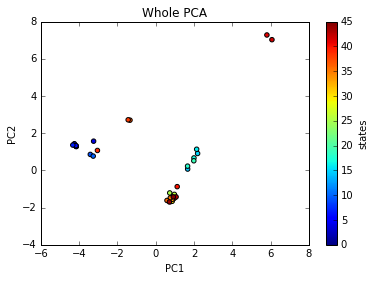

In [7]:
fig = plt.figure()
plt.scatter(whole_reduced_cartesian[:,0], whole_reduced_cartesian[:,1],c=wholetraj.time)
cbar = plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Whole PCA')
cbar.set_label('states')
plt.show()

## Projection of MD_1 on PCA mapping

In [51]:
def projection_on_pca(md_rep, molecule):
    if md_rep == '1':
        traj_location = '/media/scottzhuang/data/MD/4NPQ_PH7_md' + md_rep + '/' + molecule + '/4NPQ_' + molecule + '_md.skip100.ca.xtc'
        top_location = '/media/scottzhuang/data/MD/4NPQ_PH7_md' + md_rep + '/' + molecule + '/4NPQ_' + molecule + '_md.ca.gro'
    elif md_rep == '4HFI':
        location = '/media/scottzhuang/data/MD/4HFI_ph46_md1/'
        traj_location = location + molecule + '/mdrun/4HFI_ph46_' + molecule + '_md.skip1.ca.xtc' 
        top_location = location + molecule + '/mdrun/4HFI_ph46_' + molecule + '_md.ca.gro' 
    else:
        traj_location = '/media/scottzhuang/data/MD/4NPQ_PH7_md' + md_rep + '/' + molecule + '/4NPQ_' + molecule + '_md' + md_rep + '.skip100.ca.xtc'
        top_location = '/media/scottzhuang/data/MD/4NPQ_PH7_md' + md_rep + '/' + molecule + '/4NPQ_' + molecule + '_md' + md_rep + '.ca.gro'

    ref_location = '/media/scottzhuang/data/MD/pdb_ensemble/4NPQ_1.mer.pdb'
    traj = md.load(traj_location,top=top_location)
    ref = md.load(ref_location)
    topology = traj.topology
    traj = traj.atom_slice(topology.select(residue_selection))
    traj.superpose(wholetraj,42)
    redueced_cartesian = wholepca.transform(traj.xyz.reshape(traj.n_frames, traj.n_atoms * 3))
    fig = plt.figure()
    plt.scatter(redueced_cartesian[:,0],redueced_cartesian[:,1],c=traj.time,alpha=0.3)
    cbar = plt.colorbar()
    plt.scatter(whole_reduced_cartesian[:,0], whole_reduced_cartesian[:,1],c='black',marker='^')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('MD_' + md_rep + '  ' + molecule + ' Projection on Whole PCA')
    cbar.set_label('time')
    plt.show()

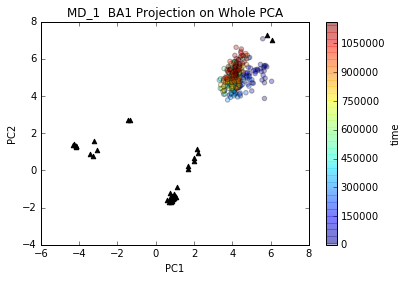

In [8]:
projection_on_pca("1",'BA1')

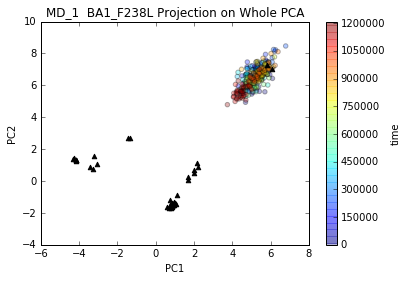

In [9]:
projection_on_pca("1",'BA1_F238L')

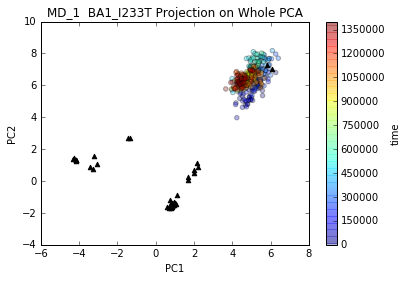

In [10]:
projection_on_pca("1",'BA1_I233T')

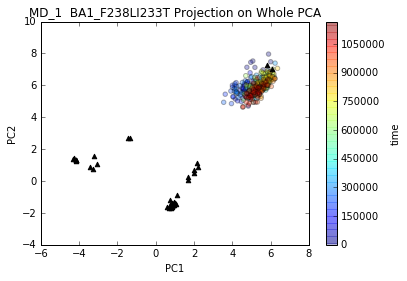

In [11]:
projection_on_pca("1",'BA1_F238LI233T')

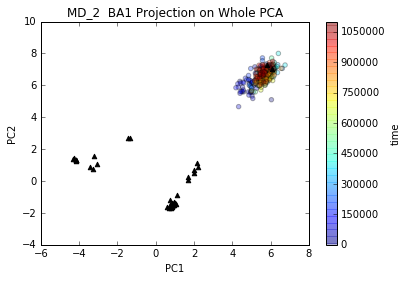

In [12]:
projection_on_pca("2",'BA1')

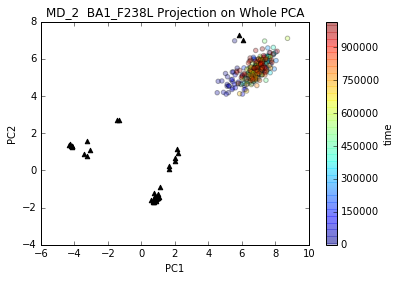

In [13]:
projection_on_pca("2",'BA1_F238L')

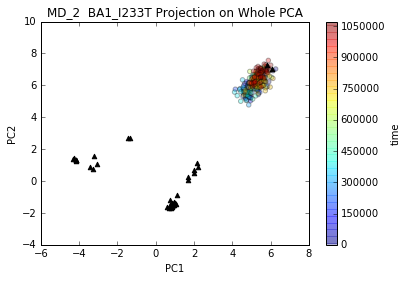

In [14]:
projection_on_pca("2",'BA1_I233T')

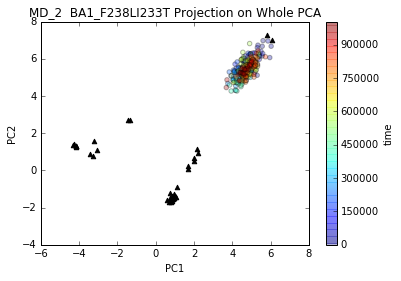

In [15]:
projection_on_pca("2",'BA1_F238LI233T')

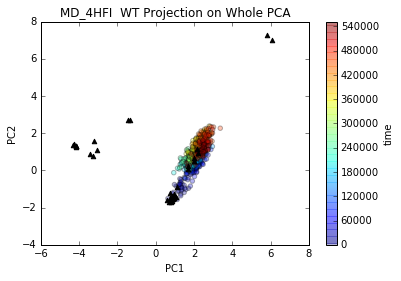

In [45]:
projection_on_pca("4HFI","WT")

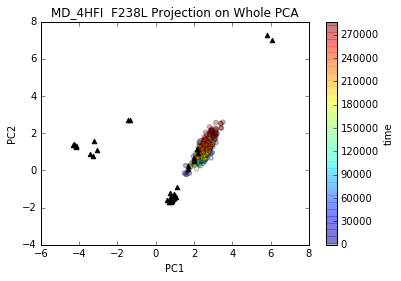

In [46]:
projection_on_pca("4HFI","F238L")

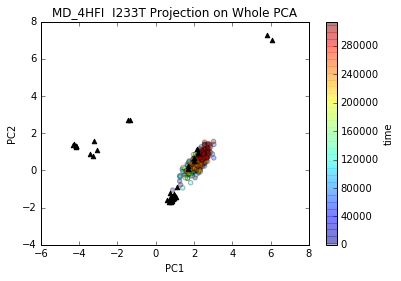

In [47]:
projection_on_pca("4HFI","I233T")

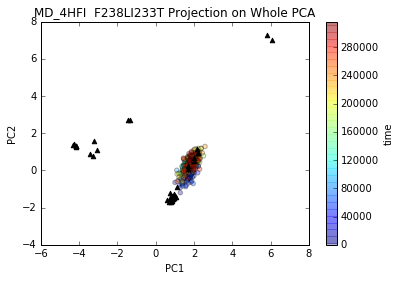

In [48]:
projection_on_pca("4HFI","F238LI233T")

## Mahalanobis Clustering

In [16]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [71]:
def MahalanobisClustering(md_rep,molecule):
    if md_rep == '1':
        traj_location = '/media/scottzhuang/data/MD/4NPQ_PH7_md' + md_rep + '/' + molecule + '/4NPQ_' + molecule + '_md.skip100.ca.xtc'
        top_location = '/media/scottzhuang/data/MD/4NPQ_PH7_md' + md_rep + '/' + molecule + '/4NPQ_' + molecule + '_md.ca.gro'
        ref_location = '/media/scottzhuang/data/MD/pdb_ensemble/4NPQ_1.mer.pdb'
    elif md_rep == "4HFI":
        location = '/media/scottzhuang/data/MD/4HFI_ph46_md1/'
        traj_location = location + molecule + '/mdrun/4HFI_ph46_' + molecule + '_md.skip1.ca.xtc' 
        top_location = location + molecule + '/mdrun/4HFI_ph46_' + molecule + '_md.ca.gro' 
        ref_location = '/media/scottzhuang/data/MD/pdb_ensemble/4HFI_1.mer.pdb'
    else:
        traj_location = '/media/scottzhuang/data/MD/4NPQ_PH7_md' + md_rep + '/' + molecule + '/4NPQ_' + molecule + '_md' + md_rep + '.skip100.ca.xtc'
        top_location = '/media/scottzhuang/data/MD/4NPQ_PH7_md' + md_rep + '/' + molecule + '/4NPQ_' + molecule + '_md' + md_rep + '.ca.gro'
        ref_location = '/media/scottzhuang/data/MD/pdb_ensemble/4NPQ_1.mer.pdb'
    
    traj = md.load(traj_location,top=top_location)
    ref = md.load(ref_location)
    topology = traj.topology
    traj = traj.atom_slice(topology.select(residue_selection))
    traj.superpose(wholetraj,42)
    reduced_cartesian = wholepca.transform(traj.xyz.reshape(traj.n_frames, traj.n_atoms * 3))
    gmm = mixture.GaussianMixture(n_components=4, covariance_type='full')    
    gmm.fit(whole_reduced_cartesian)
    fig = plt.figure()
    for frame in range (0, traj.n_frames):
        y_xrd = gmm.predict(whole_reduced_cartesian)
        y_pred = gmm.predict(reduced_cartesian)
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                 '#f781bf', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))
        plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:, 1], s=10, color=colors[y_pred],alpha=0.5)
    for frame in range (0,wholetraj.n_frames):
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                 '#f781bf', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_xrd) + 1))))
        plt.scatter(whole_reduced_cartesian[:,0], whole_reduced_cartesian[:,1],color=colors[y_xrd],marker='^')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
    fig = plt.figure()
    plt.scatter(reduced_cartesian[:,0],reduced_cartesian[:,1],c=traj.time,alpha=0.3)
    cbar = plt.colorbar()
    plt.scatter(whole_reduced_cartesian[:,0], whole_reduced_cartesian[:,1],c='black',marker='^')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('MD_' + md_rep + '  ' + molecule + ' Projection on Whole PCA')
    cbar.set_label('time')
    plt.show()

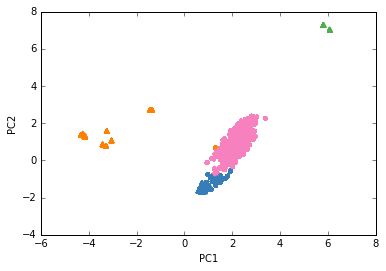

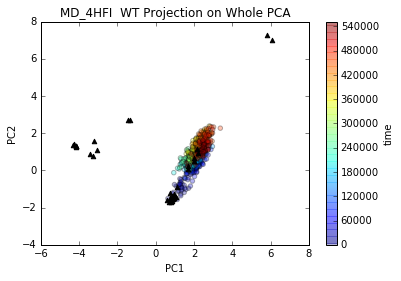

In [72]:
MahalanobisClustering("4HFI","WT")

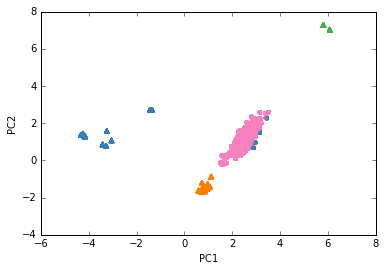

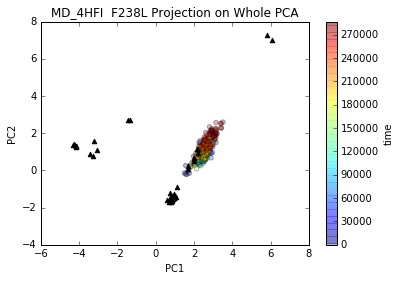

In [73]:
MahalanobisClustering("4HFI","F238L")

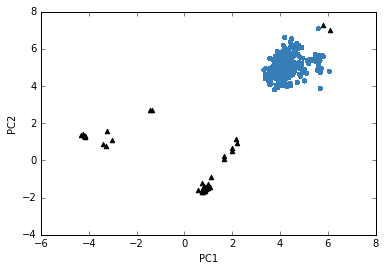

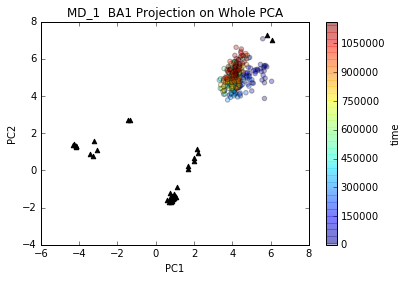

In [18]:
MahalanobisClustering("1","BA1")

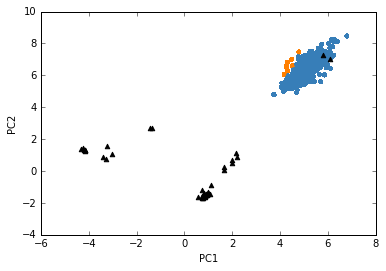

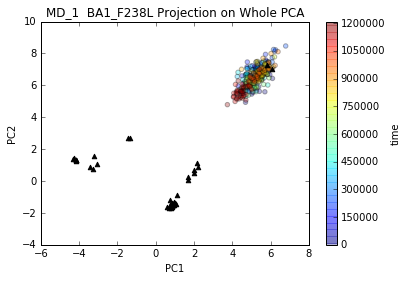

In [19]:
MahalanobisClustering("1","BA1_F238L")

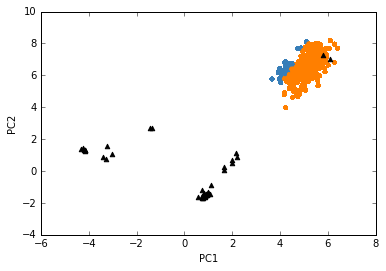

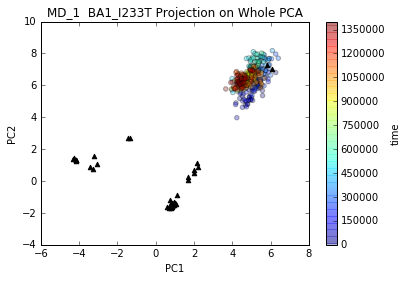

In [20]:
MahalanobisClustering("1","BA1_I233T")

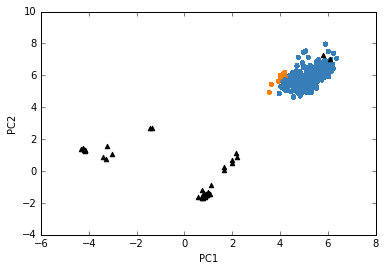

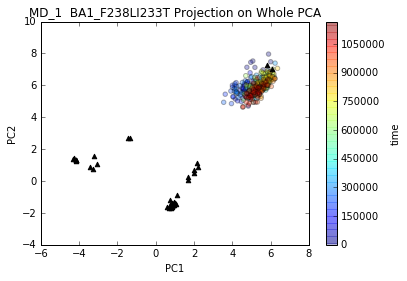

In [21]:
MahalanobisClustering("1","BA1_F238LI233T")

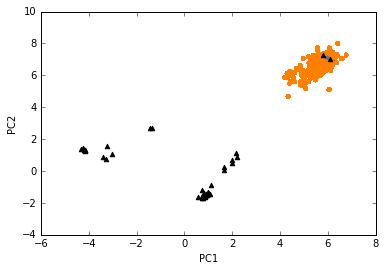

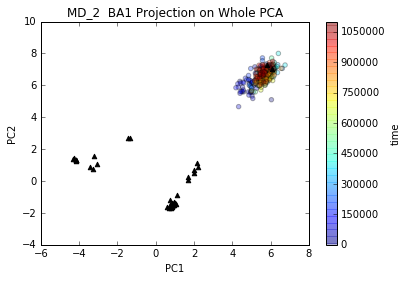

In [22]:
MahalanobisClustering("2","BA1")

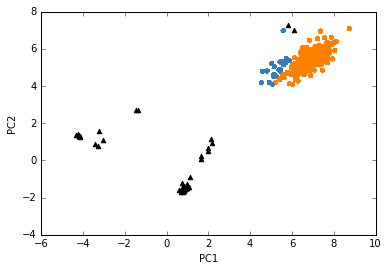

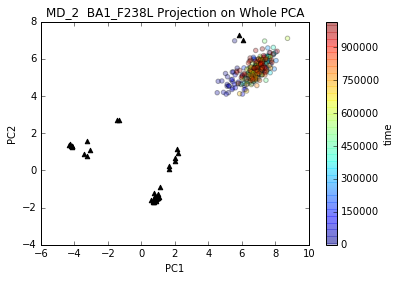

In [23]:
MahalanobisClustering("2","BA1_F238L")

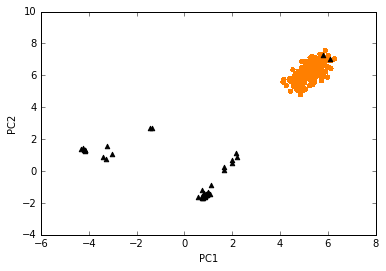

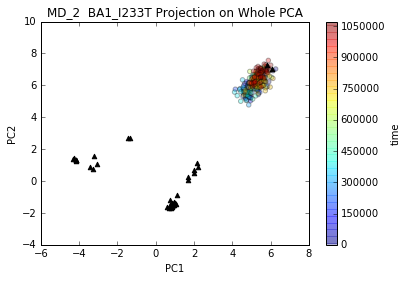

In [24]:
MahalanobisClustering("2","BA1_I233T")

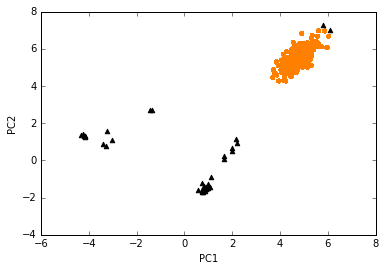

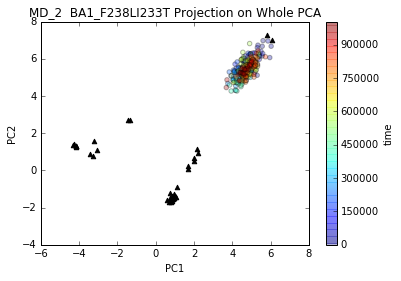

In [25]:
MahalanobisClustering("2","BA1_F238LI233T")

## New Replicas

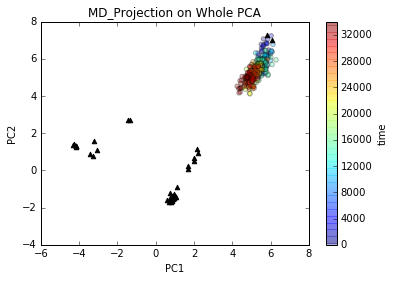

In [11]:
traj_location = '/media/scottzhuang/data/MD/md_prep/4NPQ_BA1_ph70/md.skip1.ca.xtc'
top_location = '/media/scottzhuang/data/MD/md_prep/4NPQ_BA1_ph70/md_ca.gro'
ref_location = '/media/scottzhuang/data/MD/pdb_ensemble/4NPQ_1.mer.pdb'
traj = md.load(traj_location,top=top_location)
ref = md.load(ref_location)
topology = traj.topology
traj = traj.atom_slice(topology.select(residue_selection))
traj.superpose(wholetraj,42)
redueced_cartesian = wholepca.transform(traj.xyz.reshape(traj.n_frames, traj.n_atoms * 3))
fig = plt.figure()
plt.scatter(redueced_cartesian[:,0],redueced_cartesian[:,1],c=traj.time,alpha=0.3)
cbar = plt.colorbar()
plt.scatter(whole_reduced_cartesian[:,0], whole_reduced_cartesian[:,1],c='black',marker='^')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('MD_' + 'Projection on Whole PCA')
cbar.set_label('time')
plt.show()